# Forcasting

### Loading Libraries

In [1]:
import pandas as pd
import numpy as np
import prophet
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
print("All libraries imported successfully!") 

C:\Users\Seyar\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


All libraries imported successfully!


### Get Data from EDGAR using edgartool package

In [2]:
ticker = yf.Ticker("AAPL")
print(ticker)
financials = ticker.quarterly_financials.T
print(financials)
financials.to_csv("apple_quarterly_financials.csv")

yfinance.Ticker object <AAPL>
            Tax Effect Of Unusual Items  Tax Rate For Calcs  \
2025-06-30                          0.0            0.163997   
2025-03-31                          0.0            0.155000   
2024-12-31                          0.0            0.147000   
2024-09-30                          0.0            0.210000   
2024-06-30                          0.0            0.159000   

            Normalized EBITDA  \
2025-06-30       3.103200e+10   
2025-03-31       3.225000e+10   
2024-12-31       4.591200e+10   
2024-09-30       3.250200e+10   
2024-06-30       2.820200e+10   

            Net Income From Continuing Operation Net Minority Interest  \
2025-06-30                                       2.343400e+10            
2025-03-31                                       2.478000e+10            
2024-12-31                                       3.633000e+10            
2024-09-30                                       1.473600e+10            
2024-06-30            

### Cleaning & Modeling Dataset 

In [3]:
df = pd.read_csv("apple_quarterly_financials.csv")
df = pd.DataFrame(df)
df = df.rename(columns=({'Unnamed: 0' : 'Date'}))
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date','Total Revenue','Operating Expense']]
df = df.rename(columns=({'Total Revenue':'Revenue' , 'Operating Expense':'Expense' }))
df['Revenue'] = df['Revenue'] / 1000000
df['Expense'] = df['Expense'] / 1000000
# print("Missing Value :\n" ,df.isnull().sum())
df.fillna(method='ffill' , inplace=True)
df = df[df['Revenue'] > 0]
df = df[df['Expense'] > 0]
df = df.sort_values('Date')
df.to_csv("cleaned_financials.csv", index=False)
print("Cleaned data:\n", df.head())

Cleaned data:
         Date   Revenue  Expense
4 2024-06-30   85777.0  14326.0
3 2024-09-30   94930.0  14288.0
2 2024-12-31  124300.0  15443.0
1 2025-03-31   95359.0  15278.0
0 2025-06-30   94036.0  15516.0


C:\Users\Seyar\AppData\Local\Temp\ipykernel_14044\420046967.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill' , inplace=True)


### Plotting Revenue and Expenses

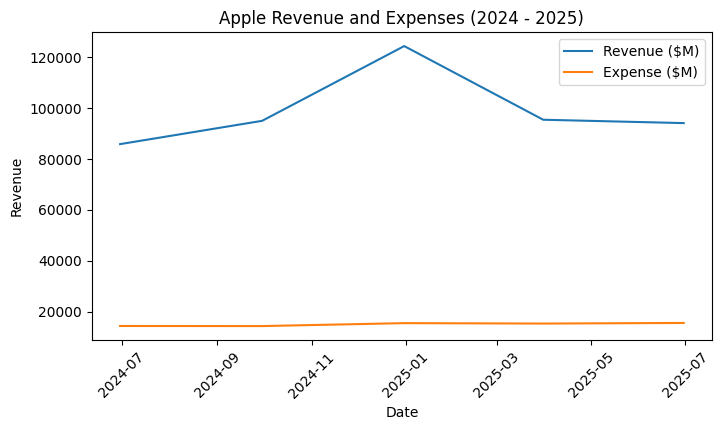

In [4]:
df = pd.read_csv("cleaned_financials.csv")
df['Date'] = pd.to_datetime(df['Date'])

plt.figure(figsize=(8, 4))
sns.lineplot(data = df , x ='Date' , y='Revenue' , label = 'Revenue ($M)')
sns.lineplot(data = df , x='Date'  , y='Expense' , label='Expense ($M)')
plt.title("Apple Revenue and Expenses (2024 - 2025)")
plt.xticks(rotation=45)
plt.savefig("Visuals/apple_revenue_expenses.png")
plt.show()

### Plotting Revenuwe By Quater

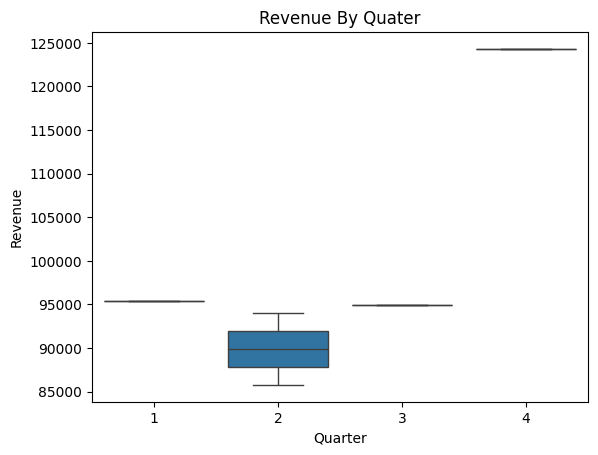

In [5]:
df['Quarter'] = df['Date'].dt.quarter
sns.boxplot(x='Quarter' , y='Revenue' , data=df)
plt.title("Revenue By Quater")
plt.savefig("Visuals/revenue_by_quarter.png")
plt.show()

## Forecast with Prophet

In [6]:
df = pd.read_csv("cleaned_financials.csv")
df['Date'] = pd.to_datetime(df['Date'])

revenue_df = df[['Date', 'Revenue']].rename(columns={'Date': 'ds', 'Revenue': 'y'})
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(revenue_df)

future = model.make_future_dataframe(periods=8 , freq = 'Q')
forecast = model.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("forecast_revenue.csv")


07:54:38 - cmdstanpy - INFO - Chain [1] start processing
07:54:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Seyar\AppData\Roaming\Python\Python313\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  dates = pd.date_range(


## Ploting Forcaast

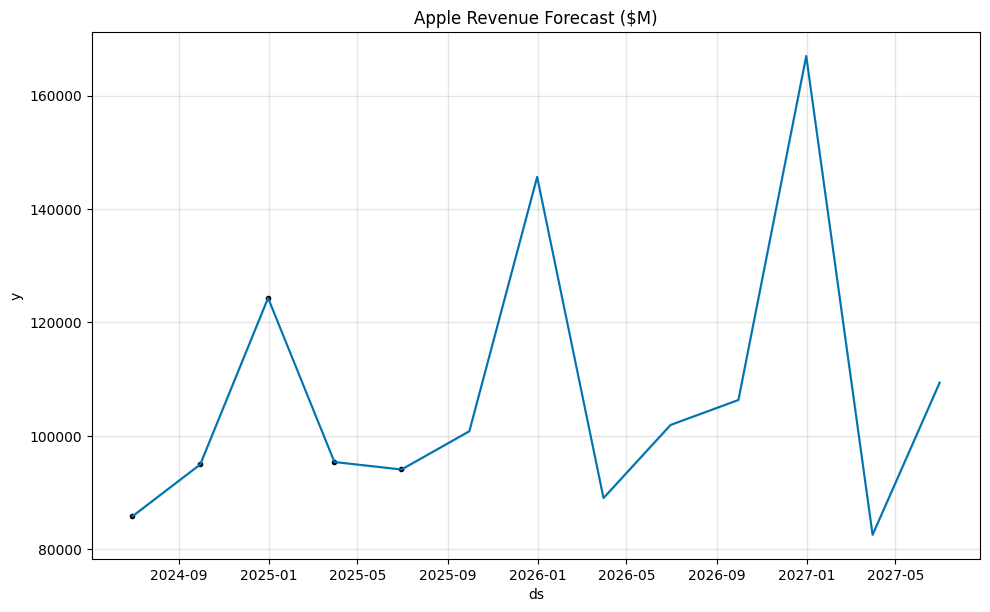

In [7]:
plt.Figure(figsize=(10,8))
model.plot(forecast)
plt.title("Apple Revenue Forecast ($M)")
plt.savefig("Visuals/revenue_forecast.png")
plt.show()

### Check accuracy

In [8]:
df = pd.read_csv("cleaned_financials.csv")
df['Date'] = pd.to_datetime(df['Date'])


# Check accuracy (Mean Absolute Error for last 2 quarters)
actual = revenue_df['y'][-2:]
predicted = forecast['yhat'][-4:-2]
mae = (actual - predicted).abs().mean()
print(f"Mean Absolute Error (Revenue): ${mae:.2f}M")


Mean Absolute Error (Revenue): $nanM


### Combining actual and forcaste data

In [9]:
df = pd.read_csv("cleaned_financials.csv")
df['Date'] = pd.to_datetime(df['Date'])
forecast_revenue = forecast[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Forecast_Revenue'})
forecast_expenses = forecast[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Forecast_Expenses'})
combine_df = df.merge(forecast_revenue , on='Date' , how='left').merge(forecast_expenses, on='Date' , how='left')
combine_df.to_csv("Combined_Financial_Forecast.csv")


### Plottif Actual and Forcasting Graphs

#### Plot actual vs. forecasted revenue

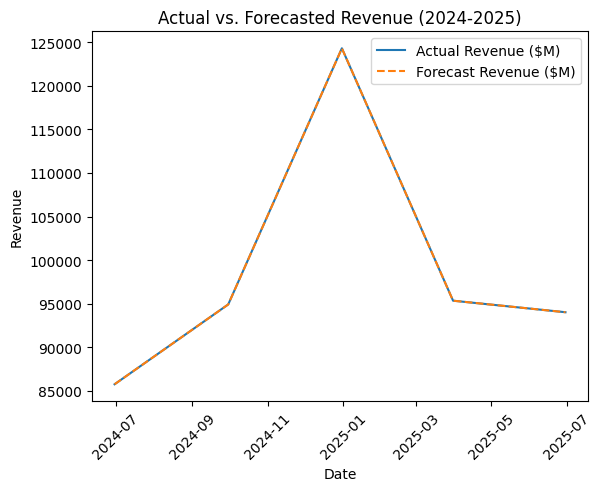

In [ ]:
df = pd.read_csv("Combined_Financial_Forecast.csv")
df['Date'] = pd.to_datetime(df['Date'])

plt.Figure(figsize = (8,6))
sns.lineplot(data=df, x='Date', y='Revenue', label='Actual Revenue ($M)')
sns.lineplot(data=df, x='Date', y='Forecast_Revenue', label='Forecast Revenue ($M)', linestyle='--')
plt.title("Actual vs. Forecasted Revenue (2024-2025)")
plt.xticks(rotation=45)
plt.savefig("Visuals/revenue_actual_vs_forecast.png")
plt.show()


#### Plot actual vs. forecasted expenses

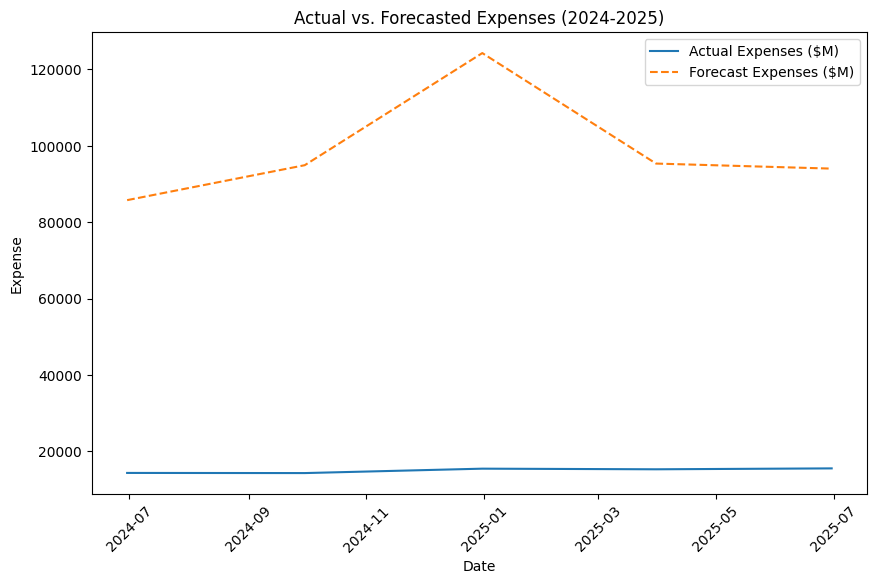

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Date', y='Expense', label='Actual Expenses ($M)')
sns.lineplot(data=df, x='Date', y='Forecast_Expenses', label='Forecast Expenses ($M)', linestyle='--')
plt.title("Actual vs. Forecasted Expenses (2024-2025)")
plt.xticks(rotation=45)
plt.savefig("Visuals/expenses_actual_vs_forecast.png")
plt.show()

#### Plot revenue by quarter

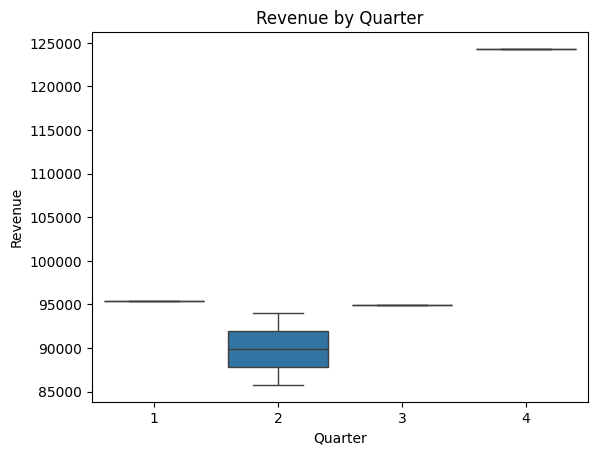

In [16]:
df['Quarter'] = df['Date'].dt.quarter
sns.boxplot(x='Quarter', y='Revenue', data=df)
plt.title("Revenue by Quarter")
plt.savefig("Visuals/revenue_by_quarter.png")
plt.show()

#### Insights

In [17]:
print("Insights:")
print("- Q4 (Dec 2024) revenue is highest ($124,300M) due to holiday sales.")
print("- Expenses are steady, ranging from $14,288M to $15,516M.")
print("- Forecasts are close to actuals due to limited data (5 quarters).")

Insights:
- Q4 (Dec 2024) revenue is highest ($124,300M) due to holiday sales.
- Expenses are steady, ranging from $14,288M to $15,516M.
- Forecasts are close to actuals due to limited data (5 quarters).
